Computer: server
Computer: server
/experiment/export_data/data_play/ZKawakeM72_013_e_010_spikes.mat
/experiment/export_data/data_play/ZKawakeM72_013_f_010_spikes.mat
['ZKawakeM72_013_f_010', 'ZKawakeM72_013_e_010']
['/experiment/export_data/data_play/ZKawakeM72_013_f_trial.mat', '/experiment/export_data/data_play/ZKawakeM72_013_e_trial.mat']
/experiment/export_data/data_play/ZKawakeM72_013_f_trial.mat
/experiment/export_data/data_play/ZKawakeM72_013_e_trial.mat
['/experiment/export_data/data_play/ZKawakeM72_013_f_noStimSniff.mat', '/experiment/export_data/data_play/ZKawakeM72_013_e_noStimSniff.mat']
/experiment/export_data/data_play/ZKawakeM72_013_f_noStimSniff.mat
/experiment/export_data/data_play/ZKawakeM72_013_e_noStimSniff.mat
/experiment/export_data/data_play/ZKawakeM72_013_e_011_spikes.mat
['ZKawakeM72_013_e_011']
[]
[]


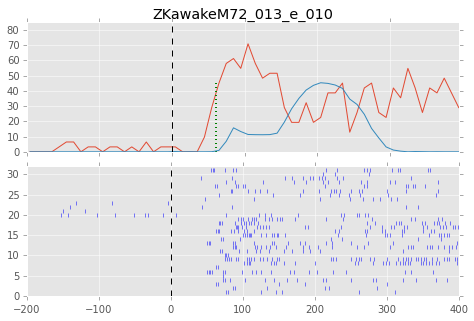

In [1]:
%matplotlib inline
from __future__ import division
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os

matplotlib.style.use('ggplot')

comp_name=socket.gethostname()
if  comp_name == 'Ezequiels-MacBook-Pro.local':
    print 'Computer: ' + comp_name
    sys.path.append('/Users/zeke/experiment/ephysDataManagement/ephysScripts')
    experiment_folder = os.path.join('/Users','zeke','experiment')
else:
    print 'Computer: ' + 'server'
    sys.path.append('/experiment/ephysDataManagement/ephysScripts')
    experiment_folder = os.path.join('/','experiment')
    
import unitToolsv2
from data_handling import ephys_names as en
from data_handling.basic_plot import decim, plot_raster, make_psth, col_binned
from data_handling import data_load as dl
from data_handling.data_load import get_warping_parameters
from analysis import stimulus as st
from analysis import response_functions as rf


#load all the records, to not load all the records for every stimulus
fn = en.file_names(root = experiment_folder)
cells_path = os.path.join(fn.fold_exp_data, 'data_play')
all_records = dl.load_cells(cells_path)

## create a stimulus and initialize it (load its responses)
high_2hydroxy = st.Odor(['2-hydroxyacetophenone','2hydroxyacetophenone'], 0.0051)
st_1 = st.Stimulus(high_2hydroxy, records = all_records, tags = {'light':1} )
#get the first response and plot it

st_1.responses['ZKawakeM72_013_e_010'].get_response_onset(warped=False)
rp = st_1.responses['ZKawakeM72_013_e_010'].plot(warped=False)

#[r.plot(warped=True) for r in list(st_1.responses.values())]

In [6]:
c=4
a = 1 if c==4 else 0
print a

1


In [2]:
# initialize ipython "cluster" first.
# this connects client to the cluster workers.

from IPython.parallel import Client
C = Client(profile='default')
lbv = C.load_balanced_view()

In [2]:
# I'm defining the draw_and_mean as a nested function here because

def parfunc(stimulus_sa, baseline_sa):
    """
    stimulus_sa: numpy array of shape (n_bins, n_trials)
    
    """
    import numpy as np
    from scipy.stats import ks_2samp
    
    def draw_and_mean(spike_array, n_bs, n_trials):
        # draw= np.empty_like(bl_sa)
        draw_indexes = np.random.randint(0, spike_array.shape[1]-1, (n_bs, n_trials))
        psths = np.empty((n_bs, spike_array.shape[0]))
        for i in xrange(n_bs):
            draw_is = draw_indexes[i]
            draw = spike_array[:, draw_is]
            psths[i, :] = draw.mean(axis=1)
        return psths
    
    """
    spike arrays are each numpy.array of shape (n_bins, n_trials) (for baseline it's actually n_sniffs instead of trials)
    spike arrays here are normalized (Hz).
    """
    assert(stimulus_sa.shape[0]==baseline_sa.shape[0])
    
    response_mean = stimulus_sa.mean(axis=1)
    ntr = stimulus_sa.shape[1] # number of trials in stimulus.
    baseline_boot = draw_and_mean(baseline_sa, 100000, ntr)

    ps = np.empty_like(response_mean)
    ks = np.empty_like(response_mean)
    kst = np.empty_like(response_mean)
    for j in xrange(len(response_mean)):
        r = response_mean[j]
        base = baseline_boot[:, j]
    #     print base.shape
        p = np.sum(base >= r)/len(base)
        ps[j] = p
        kst[j], ks[j] = ks_2samp(stimulus_sa[j,:],baseline_sa[j,:])
    ps = np.asarray(ps)
    

    
    return ps, baseline_boot, ks, kst

In [99]:
import numpy as np
from scipy.stats import ks_2samp
import itertools
from data_handling.data_load import get_warping_parameters

def raster_compare(stimulus_sa, baseline_sa, bootstrap = False):
    """
    stimulus_sa: numpy array of shape (n_bins, n_trials)
    baseline_sa: numpy array of shape (n_bins, n_sniffs)
    """
    
    def draw_and_mean(spike_array, n_bs, n_trials):
        # draw= np.empty_like(bl_sa)
        draw_indexes = np.random.randint(0, spike_array.shape[1]-1, (n_bs, n_trials))
        psths = np.empty((n_bs, spike_array.shape[0]))
        for i in xrange(n_bs):
            draw_is = draw_indexes[i]
            draw = spike_array[:, draw_is]
            psths[i, :] = draw.mean(axis=1)
        return psths
    
    """
    spike arrays are each numpy.array of shape (n_bins, n_trials) (for baseline it's actually n_sniffs instead of trials)
    spike arrays here are normalized (Hz).
    """
    assert(stimulus_sa.shape[0]==baseline_sa.shape[0])
    
    response_mean = stimulus_sa.mean(axis=1)
    ntr = stimulus_sa.shape[1] # number of trials in stimulus.
    
    ks_p = np.empty_like(response_mean)
    ks_stat = np.empty_like(response_mean)
    for j in xrange(len(response_mean)):
        r = response_mean[j]
        ks_stat[j], ks_p[j] = ks_2samp(stimulus_sa[j,:],baseline_sa[j,:])
    
    
    if bootstrap:
        baseline_boot = draw_and_mean(baseline_sa, 100000, ntr)
        ps = np.empty_like(response_mean)
        for j in xrange(len(response_mean)):
            r = response_mean[j]
            base = baseline_boot[:, j]
            p = np.sum(base >= r)/len(base)
            ps[j] = p
        ps = np.asarray(ps)      
    else:
        ps = None
        baseline_boot = None
        
    return ps, baseline_boot, ks_p, ks_stat
        
        
def find_onset(response, bin_size = 10, t_post=0, p=0.01, warped=False):
    
    if t_post==0:
        all_sniffs = np.sort(response.baseline.sniff_data, order=['inh_len', 't_0'])
        if warped:
            inh_len, exh_len = get_warping_parameters(all_sniffs, means=False)
        else:
            inh_len, exh_len = get_warping_parameters(all_sniffs, means=True)
        t_post = inh_len + exh_len


    rst_sa = col_binned(response.make_raster(t_pre=0, t_post=t_post, warped=warped), bin_size).transpose()
    bl_sa = col_binned(response.baseline.make_raster(t_pre=0, t_post=t_post, warped=warped),bin_size).transpose()

    # get the statistics
    _, _, ks, kst = raster_compare(rst_sa, bl_sa, bootstrap = False)

    # debugging
    t_pre = 0
    rst = response.make_raster(warped=warped, t_pre=0, t_post=t_post)
    bl=response.baseline.make_raster(t_pre=0, t_post=t_post, warped=warped)
    events   = bl.shape[0]
    t_stamps = bl.shape[1]
    t=np.arange(t_stamps)
    t_dec = decim(t, bin_size)
    #plot_raster(bl, t0=t_pre, t2=t_post, bin_size=bin_size)
    #plot_raster(rst, t0=t_pre, t2=t_post, bin_size=bin_size)
    plt.plot(t_dec, rst_sa.mean(axis=1))
    plt.plot(t_dec, bl_sa.mean(axis=1))
    #plt.plot(t_dec, psths[t_post//bin_size, :])
    response_mean = rst_sa.mean(axis=1)
    #plt.plot(t_dec, psths.mean(axis=0))
    plt.figure()
    plt.plot(t_dec, ks)
    #plt.plot(t_dec, ps)

    #find the first significant difference
    onset = next(itertools.ifilter(lambda i: ks[i] < p, range(len(ks))), None)
    if onset is not None:
        is_supra = rst_sa.mean(axis=1)[onset] > bl_sa.mean(axis=1)[onset]
    else:
        onset = np.nan
        is_supra = None
    
    return onset, is_supra

def find_detailed_onset(response, bin_size=10, precision=1, p_ks=0.005, p_bs=0.001, warped=False, t_post=500):
    #get the bin onset using the KS test and a large bin_size
    onset, is_supra = find_onset(response, bin_size=bin_size, p=p_ks, warped=warped)
    
    if onset is np.nan:
        return onset, np.nan, np.nan, np.nan, np.nan
    
    #now get a more detailed one using the bootstrap over a two-bin window
    t1 = int(round(onset-1)*bin_size)
    t1 = max(0, t1)
    t2 = t1 + 2*bin_size
    rst = response.make_raster(t_pre=0, t_post=t2, warped=warped)[:,t1:t2]
    bl= response.baseline.make_raster(t_pre=0, t_post=t2, warped=warped)[:,t1:t2]
    
    rst_sa = col_binned(rst, precision).transpose()
    bl_sa = col_binned(bl,precision).transpose()
    ps, baseline_boot, ks_p, ks_stat = raster_compare(rst_sa, bl_sa, bootstrap = True)
    
    
    #find the first significant difference
    det_onset = next(itertools.ifilter(lambda i: ps[i] < p_bs, range(len(ps))), None)
    if det_onset is not None:
        final_onset = det_onset + t1
    else:
        final_onset = onset * bin_size
    
    return final_onset, is_supra, ps, baseline_boot, ks_p, ks_stat
    


124
True


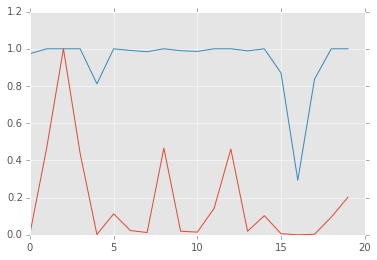

In [2]:
rec_name = 'ZKawakeM72_013_e_011'
r0=st_1.responses[rec_name]
bin_size = 10
onset, is_supra, ps, baseline_boot, ks_p, ks_stat = rf.find_detailed_onset(r0, bin_size=bin_size, p_ks=0.01, p_bs=0.005, warped=True)
print onset
print is_supra
plt.figure()
plt.plot(ps)
plt.plot(ks_p)

IndexError: tuple index out of range

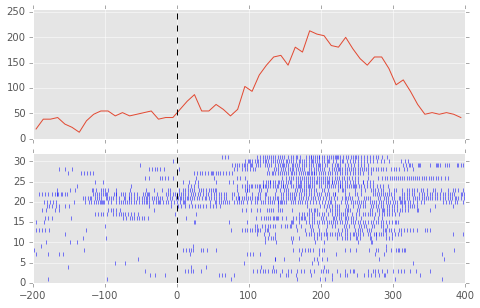

In [5]:
warp = False
r0.get_response_onset(warped=warp)
r0.plot(warped=warp)

160
True


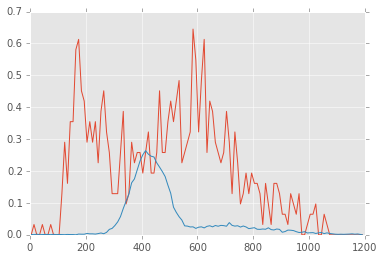

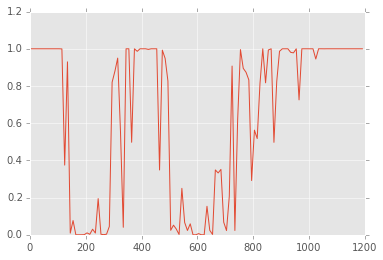

In [89]:
rec_name = 'ZKawakeM72_013_f_010'
r0=st_1.responses[rec_name]
bin_size = 10
warped = True
onset, is_supra = find_onset(r0, bin_size=bin_size, p=0.005, warped=warped)
if onset is not None:
    print onset*bin_size
    print is_supra
t1 = int(round(onset-1)*bin_size)
t1 = max(0, t1)
t2 = t1 + 2*bin_size
rst = r0.make_raster(t_pre=0, t_post=t2, warped=warped)[:,t1:]
bl= r0.baseline.make_raster(t_pre=0, t_post=t2, warped=warped)[:,t1:]

In [98]:
rst = r0.make_raster(t_pre=0, t_post=t2, warped=warped)[:, t1:t2]
bl= r0.baseline.make_raster(t_pre=0, t_post=1200, warped=warped)[:, t1:t2]
print rst.shape
print bl.shape

(31, 20)
(2642, 20)


(31, 1194)
(2642, 20)


In [53]:
onset is np.nan

True

In [84]:
print rst.shape
print bl.shape

(31, 1394)
(2642, 1394)


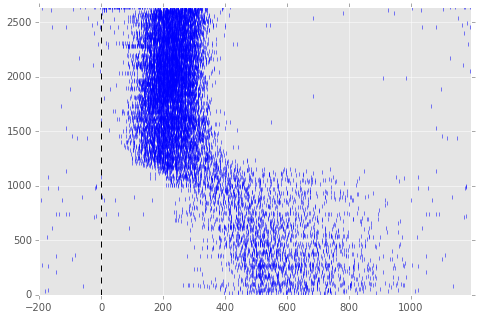

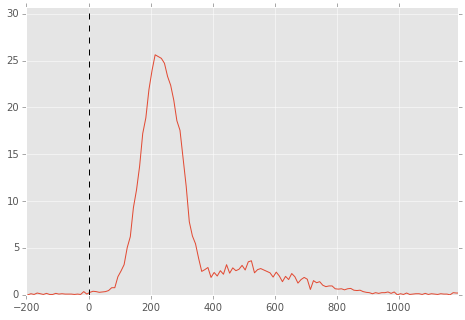

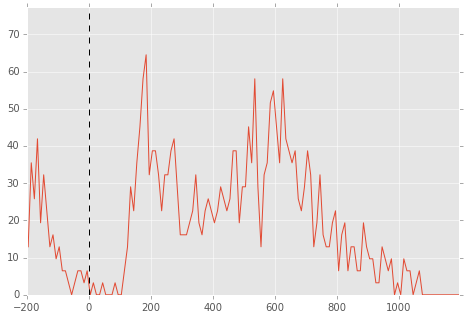

In [83]:
rec_name = 'ZKawakeM72_013_f_010'
r0=st_1.responses[rec_name]
rst = r0.make_raster(warped=True)
#plot_raster(rst, t0=200)
#plot_raster(rst, bin_size=10, t0=200)
bl=r0.baseline.make_raster(t_pre=0, t_post=1394, warped=True)
plot_raster(bl, t0=200)
plot_raster(bl, t0=200, bin_size=10)
plot_raster(rst, t0=200, bin_size=10)
bin_size = 10
events   = bl.shape[0]
t_stamps = bl.shape[1]
t=np.arange(t_stamps)-200
t_dec = decim(t, bin_size)



80


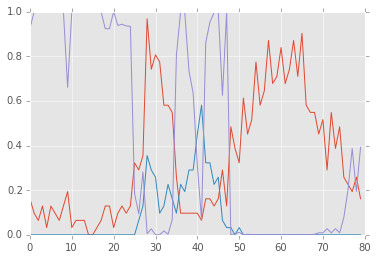

In [7]:
rec_name = 'ZKawakeM72_013_e_011'
r0=st_1.responses[rec_name]
bin_size = 10
rst_sa = col_binned(rst, bin_size).transpose()
bl_sa = col_binned(bl,bin_size).transpose()
ps, psths, ks, kst = parfunc(rst_sa, bl_sa)
response_mean = rst.transpose().mean(axis=1)
import itertools
plt.plot(rst_sa.mean(axis=1))
plt.plot(psths[800//bin_size, :])
#plt.plot(psths.mean(axis=0))
plt.plot(ks)
#find first ks<p
p=0.01
seq = ks<p
onset = next(i for i in range(len(ks)) if ks[i]<p)
print onset*bin_size-200

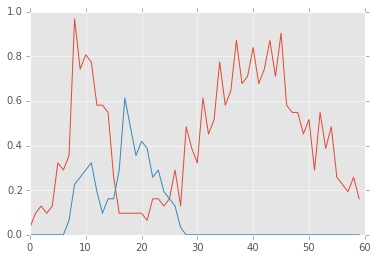

In [11]:
plt.plot(rst_sa.mean(axis=1))
plt.plot(psths[800//bin_size, :])

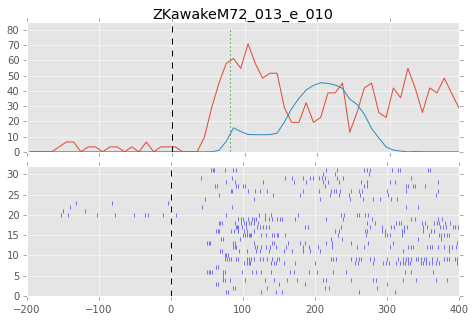

In [28]:
rp=st_1.responses['ZKawakeM72_013_e_010'].plot(warped=False)
ax1=rp['ax_stack'].get('psth')
ax1.plot((80, 80), (80, 0), 'g:')

In [2]:
a = np.arange(28).reshape((4,7))
print a

print col_binned(a, 4)


[[ 0  1  2  3  4  5  6]
 [ 7  8  9 10 11 12 13]
 [14 15 16 17 18 19 20]
 [21 22 23 24 25 26 27]]
[[  6.  15.]
 [ 34.  36.]
 [ 62.  57.]
 [ 90.  78.]]


In [14]:

a

['__class__',
 '__delattr__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']